In [1]:
# to auto reload the modified module
% load_ext autoreload
% autoreload 2

In [13]:
import tensorflow as tf
import numpy as np
import random
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import gc

from utils import *
from data import MnistTF
from nn_kd import *
from layers import *
# from models import *

In [3]:
# session settings
session = create_session(gpu_id='1')
# seed settings
set_rand_seed(0)

In [5]:
# read Mnist data
try_cls2 = True
if try_cls2:
    mnist = MnistTF()
    X_train, y_train = mnist.get_train_data()
    X_val, y_val = mnist.get_validation_data()
    X_test, y_test = mnist.get_test_data()
    print_obj(X_train, 'X_train')
    print_obj(y_train, 'y_train')
    print_obj(X_val, 'X_val')
    print_obj(y_val, 'y_val')
    print_obj(X_test, 'X_test')
    print_obj(y_test, 'y_test')
    input_dims = X_train.shape[1]
    output_dims = y_train.shape[1]
    print_obj(input_dims, 'input_dims')
    print_obj(output_dims, 'output_dims')


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
X_train <class 'numpy.ndarray'> (55000, 784)
y_train <class 'numpy.ndarray'> (55000, 10)
X_val <class 'numpy.ndarray'> (5000, 784)
y_val <class 'numpy.ndarray'> (5000, 10)
X_test <class 'numpy.ndarray'> (10000, 784)
y_test <class 'numpy.ndarray'> (10000, 10)
input_dims <class 'int'> 784
output_dims <class 'int'> 10


In [7]:
def build_big_model(input_dims, output_dims, session):

    bigmodel = SoftenedNN(
        input_dims=input_dims
        , output_dims=output_dims
        , session=session
        , dtype_X=tf.float32
        , dtype_y=tf.float32)

    bigmodel.add_layer(
        FC(inputs=bigmodel.h[-1],out_dims=512, activation_fn=tf.nn.relu))
    bigmodel.add_layer(
        Dropout(inputs=bigmodel.h[-1], keep_prob=0.7))
    bigmodel.add_layer(
        FC(inputs=bigmodel.h[-1],out_dims=512, activation_fn=tf.nn.relu))
    bigmodel.add_layer(
        Dropout(inputs=bigmodel.h[-1], keep_prob=0.7))
    bigmodel.add_layer(
        FC(inputs=bigmodel.h[-1],out_dims=output_dims, activation_fn=tf.nn.softmax))

    bigmodel.compile_nn(
        loss=tf.losses.softmax_cross_entropy(bigmodel.ys,bigmodel.logits)
        , opt=tf.train.AdamOptimizer(learning_rate=1e-3)
        , metrics = ['acc'])

    return bigmodel

In [16]:
def build_small_model(input_dims, output_dims, session, is_student):

    smallmodel = StudentNN(
        input_dims=input_dims
        , output_dims=output_dims
        , session=session
        , dtype_X=tf.float32
        , dtype_y=tf.float32)

    smallmodel.add_layer(
        FC(inputs=smallmodel.h[-1],out_dims=4,activation_fn=tf.nn.relu))
    smallmodel.add_layer(
        FC(inputs=smallmodel.h[-1],out_dims=output_dims, activation_fn=tf.nn.softmax))

    if is_student:
        smallmodel.compile_student(
            loss_standard=tf.losses.softmax_cross_entropy(smallmodel.ys,smallmodel.logits)
            , opt=tf.train.AdamOptimizer(learning_rate=1e-3) #TODO: higher learning rate
            , metrics = ['acc']) # BUGFIX: logits_with_T still None currently
    else:
        smallmodel.compile_nn(
            loss=tf.losses.softmax_cross_entropy(smallmodel.ys,smallmodel.logits)
            , opt=tf.train.AdamOptimizer(learning_rate=1e-3)
            , metrics = ['acc']) # BUGFIX: logits_with_T still None currently
    return smallmodel

In [14]:
if try_cls2:
    teacher = build_big_model(input_dims, output_dims, session)
    teacher.train(
        X=X_train
        ,y=y_train
        ,val_set=[X_val,y_val]
        ,batch_size=32
        ,n_epochs=20
        ,display_steps=100)

Epoch 1 , step 0 , loss= 3.2116785 val_loss= 3.881226 , acc = 0.25 val acc = 0.132 
Epoch 1 , step 100 , loss= 0.55827373 val_loss= 0.5321431 , acc = 0.78125 val acc = 0.8344 
Epoch 1 , step 200 , loss= 0.32872888 val_loss= 0.39927116 , acc = 0.84375 val acc = 0.8814 
Epoch 1 , step 300 , loss= 0.21233639 val_loss= 0.32993823 , acc = 0.8125 val acc = 0.9038 
Epoch 1 , step 400 , loss= 0.062278226 val_loss= 0.3002664 , acc = 0.9375 val acc = 0.9048 
Epoch 1 , step 500 , loss= 0.16812035 val_loss= 0.23371948 , acc = 0.875 val acc = 0.9298 
Epoch 1 , step 600 , loss= 0.11664678 val_loss= 0.25269958 , acc = 0.96875 val acc = 0.9194 
Epoch 1 , step 700 , loss= 0.28729898 val_loss= 0.22845982 , acc = 0.9375 val acc = 0.9294 
Epoch 1 , step 800 , loss= 0.28952372 val_loss= 0.1999355 , acc = 0.90625 val acc = 0.935 
Epoch 1 , step 900 , loss= 0.25255567 val_loss= 0.19905607 , acc = 0.90625 val acc = 0.9388 
Epoch 1 , step 1000 , loss= 0.04767844 val_loss= 0.18965137 , acc = 1.0 val acc = 0.944

Epoch 6 , step 410 , loss= 0.04178184 val_loss= 0.10393043 , acc = 0.96875 val acc = 0.9706 
Epoch 6 , step 510 , loss= 0.005021206 val_loss= 0.117627956 , acc = 1.0 val acc = 0.9692 
Epoch 6 , step 610 , loss= 0.044863675 val_loss= 0.11063984 , acc = 1.0 val acc = 0.9732 
Epoch 6 , step 710 , loss= 0.035820812 val_loss= 0.12887576 , acc = 1.0 val acc = 0.9668 
Epoch 6 , step 810 , loss= 0.054748848 val_loss= 0.09193783 , acc = 1.0 val acc = 0.9724 
Epoch 6 , step 910 , loss= 0.0031226068 val_loss= 0.10736117 , acc = 1.0 val acc = 0.972 
Epoch 6 , step 1010 , loss= 0.04426768 val_loss= 0.12167112 , acc = 1.0 val acc = 0.9736 
Epoch 6 , step 1110 , loss= 0.018514195 val_loss= 0.10377628 , acc = 0.96875 val acc = 0.9734 
Epoch 6 , step 1210 , loss= 0.005282606 val_loss= 0.10895442 , acc = 1.0 val acc = 0.974 
Epoch 6 , step 1310 , loss= 0.22209463 val_loss= 0.12905267 , acc = 0.96875 val acc = 0.9674 
Epoch 6 , step 1410 , loss= 0.023260722 val_loss= 0.110064134 , acc = 1.0 val acc = 0.9

Epoch 11 , step 720 , loss= 0.08203596 val_loss= 0.13095781 , acc = 1.0 val acc = 0.9738 
Epoch 11 , step 820 , loss= 0.0017845302 val_loss= 0.12683447 , acc = 1.0 val acc = 0.9736 
Epoch 11 , step 920 , loss= 0.00096724764 val_loss= 0.10578601 , acc = 1.0 val acc = 0.97 
Epoch 11 , step 1020 , loss= 0.004149238 val_loss= 0.108662926 , acc = 1.0 val acc = 0.9748 
Epoch 11 , step 1120 , loss= 0.00067636144 val_loss= 0.13855493 , acc = 1.0 val acc = 0.9752 
Epoch 11 , step 1220 , loss= 0.0025630642 val_loss= 0.14871517 , acc = 1.0 val acc = 0.9702 
Epoch 11 , step 1320 , loss= 0.00015734845 val_loss= 0.13305509 , acc = 0.96875 val acc = 0.972 
Epoch 11 , step 1420 , loss= 0.10959652 val_loss= 0.12665345 , acc = 0.96875 val acc = 0.9738 
Epoch 11 , step 1520 , loss= 0.0047371234 val_loss= 0.11201001 , acc = 1.0 val acc = 0.9744 
Epoch 11 , step 1620 , loss= 0.17331074 val_loss= 0.116804115 , acc = 0.96875 val acc = 0.9734 
Epoch 12 , step 2 , loss= 0.020157916 val_loss= 0.119692154 , acc 

Epoch 16 , step 930 , loss= 0.0010220277 val_loss= 0.14183317 , acc = 1.0 val acc = 0.9772 
Epoch 16 , step 1030 , loss= 0.06660774 val_loss= 0.12866041 , acc = 1.0 val acc = 0.9764 
Epoch 16 , step 1130 , loss= 0.010118503 val_loss= 0.12615584 , acc = 1.0 val acc = 0.9726 
Epoch 16 , step 1230 , loss= 0.00047794526 val_loss= 0.13844675 , acc = 1.0 val acc = 0.972 
Epoch 16 , step 1330 , loss= 0.0022551313 val_loss= 0.15172455 , acc = 1.0 val acc = 0.9706 
Epoch 16 , step 1430 , loss= 0.018910449 val_loss= 0.13019429 , acc = 1.0 val acc = 0.972 
Epoch 16 , step 1530 , loss= 0.00077349786 val_loss= 0.13868171 , acc = 1.0 val acc = 0.9746 
Epoch 16 , step 1630 , loss= 0.0009118201 val_loss= 0.13742769 , acc = 1.0 val acc = 0.9756 
Epoch 17 , step 12 , loss= 0.002131867 val_loss= 0.15033408 , acc = 1.0 val acc = 0.9744 
Epoch 17 , step 112 , loss= 0.0047082365 val_loss= 0.13236538 , acc = 1.0 val acc = 0.9766 
Epoch 17 , step 212 , loss= 0.009662617 val_loss= 0.123483546 , acc = 1.0 val a

Plotting loss...


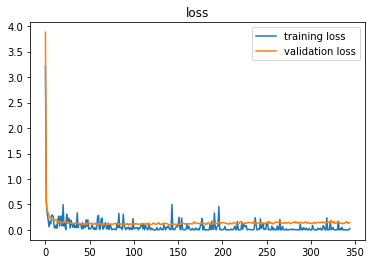

Plotting metrics...


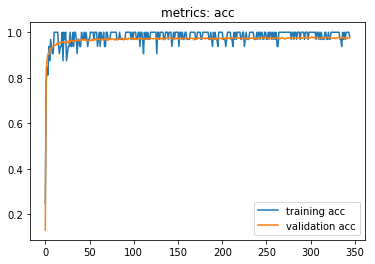

train {'acc': 0.98972726}
test {'acc': 0.9722}
{'acc': 0.9722}


In [15]:
if try_cls2:
    teacher.plt_loss()
    teacher.plt_metrics()
    train_metric = teacher.get_metrics(X_train, y_train)
    test_metric = teacher.get_metrics(X_test, y_test)
    print('train',train_metric)
    print('test',test_metric)
    print(test_metric)

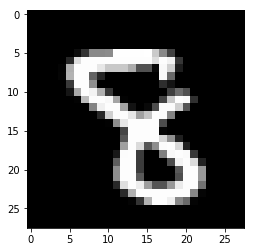

sample.max() 1.0
label [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
teacher.predict [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
teacher.predict_softened [[0.0049 0.0086 0.0224 0.0514 0.0037 0.013  0.0043 0.0078 0.8664 0.0176]]


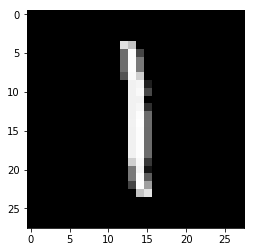

sample.max() 1.0
label [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
teacher.predict [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
teacher.predict_softened [[0.0062 0.8216 0.015  0.0092 0.011  0.0061 0.0048 0.0674 0.0289 0.0298]]


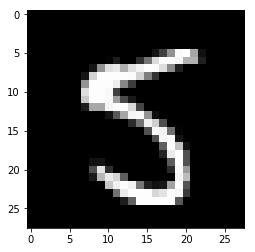

sample.max() 1.0
label [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
teacher.predict [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
teacher.predict_softened [[0.0031 0.0071 0.0067 0.1179 0.0014 0.6881 0.0194 0.0033 0.0397 0.1134]]


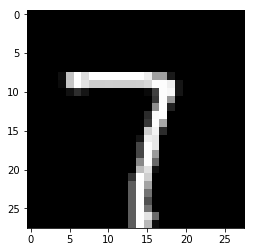

sample.max() 1.0
label [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
teacher.predict [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
teacher.predict_softened [[2.000e-04 5.400e-03 6.000e-03 3.400e-03 9.000e-04 1.000e-04 0.000e+00
  9.765e-01 4.000e-04 7.300e-03]]


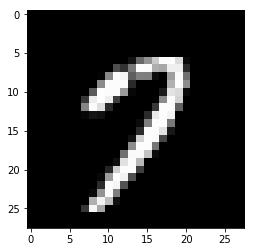

sample.max() 1.0
label [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
teacher.predict [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
teacher.predict_softened [[0.0256 0.1874 0.0735 0.0565 0.0528 0.0225 0.0166 0.4019 0.0335 0.1298]]


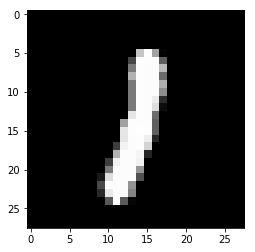

sample.max() 1.0
label [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
teacher.predict [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
teacher.predict_softened [[0.0472 0.6186 0.0351 0.0322 0.0432 0.0155 0.055  0.0613 0.0691 0.0228]]


In [22]:
# plot and show sample
if try_cls2:
    n_samples = 6
    round_show = 4
    t = 10
    X_show = X_train
    n_data = X_show.shape[0]
    indices = np.random.choice(n_data,n_samples)
    for i in range(n_samples):
        sample = X_show[[indices[i]]]
        label = y_train[indices[i]]
        plt.imshow(sample.reshape((28,28)), cmap='gray')
        plt.show()
        pred = teacher.predict(sample)
        pred_t = teacher.predict_softened(sample, temperature=t)
#         pred_t2 = y_train_soft[indices[i]]
        print('sample.max()',sample.max())
        print('label',label)
        print('teacher.predict',np.round(pred,round_show))
        print('teacher.predict_softened',np.round(pred_t,round_show))
#         print('y_soft',np.round(pred_t2,round_show))
        #     teacher.predict()

In [23]:
import gc
gc.collect()
if try_cls2:
    small = build_small_model(input_dims, output_dims, session, is_student=False)
    small.train(
        X=X_train
        ,y=y_train
        ,val_set=[X_val,y_val]
        ,batch_size=32
        ,n_epochs=20
        ,display_steps=100)

Epoch 1 , step 0 , loss= 2.2684417 val_loss= 2.2962227 , acc = 0.15625 val acc = 0.115 
Epoch 1 , step 100 , loss= 2.0082717 val_loss= 1.9693882 , acc = 0.34375 val acc = 0.3722 
Epoch 1 , step 200 , loss= 1.5610089 val_loss= 1.6033334 , acc = 0.46875 val acc = 0.4314 
Epoch 1 , step 300 , loss= 1.476911 val_loss= 1.3228816 , acc = 0.4375 val acc = 0.5482 
Epoch 1 , step 400 , loss= 0.8937344 val_loss= 1.1335009 , acc = 0.625 val acc = 0.621 
Epoch 1 , step 500 , loss= 0.93324906 val_loss= 1.026631 , acc = 0.75 val acc = 0.6718 
Epoch 1 , step 600 , loss= 0.92898875 val_loss= 0.94880134 , acc = 0.71875 val acc = 0.7096 
Epoch 1 , step 700 , loss= 1.1052141 val_loss= 0.9042365 , acc = 0.59375 val acc = 0.726 
Epoch 1 , step 800 , loss= 0.9844855 val_loss= 0.8657236 , acc = 0.65625 val acc = 0.7368 
Epoch 1 , step 900 , loss= 0.8636811 val_loss= 0.84862345 , acc = 0.78125 val acc = 0.7342 
Epoch 1 , step 1000 , loss= 0.5746373 val_loss= 0.82830936 , acc = 0.90625 val acc = 0.7478 
Epoch 

Epoch 6 , step 410 , loss= 0.61745024 val_loss= 0.5191342 , acc = 0.84375 val acc = 0.851 
Epoch 6 , step 510 , loss= 0.54395366 val_loss= 0.51358604 , acc = 0.78125 val acc = 0.851 
Epoch 6 , step 610 , loss= 0.34564498 val_loss= 0.5222274 , acc = 0.90625 val acc = 0.85 
Epoch 6 , step 710 , loss= 0.29883972 val_loss= 0.51577413 , acc = 0.84375 val acc = 0.8526 
Epoch 6 , step 810 , loss= 0.59374714 val_loss= 0.51170874 , acc = 0.8125 val acc = 0.8526 
Epoch 6 , step 910 , loss= 0.5824354 val_loss= 0.51413864 , acc = 0.84375 val acc = 0.8514 
Epoch 6 , step 1010 , loss= 0.38279942 val_loss= 0.50864774 , acc = 0.875 val acc = 0.853 
Epoch 6 , step 1110 , loss= 0.45132133 val_loss= 0.51041204 , acc = 0.90625 val acc = 0.8546 
Epoch 6 , step 1210 , loss= 0.47122058 val_loss= 0.5131209 , acc = 0.84375 val acc = 0.8544 
Epoch 6 , step 1310 , loss= 0.5535715 val_loss= 0.5066236 , acc = 0.84375 val acc = 0.8568 
Epoch 6 , step 1410 , loss= 0.4556346 val_loss= 0.50463873 , acc = 0.875 val acc

Epoch 11 , step 720 , loss= 0.3492756 val_loss= 0.46715045 , acc = 0.90625 val acc = 0.8742 
Epoch 11 , step 820 , loss= 0.3305004 val_loss= 0.46584824 , acc = 0.875 val acc = 0.8698 
Epoch 11 , step 920 , loss= 0.20350483 val_loss= 0.47843194 , acc = 0.96875 val acc = 0.8714 
Epoch 11 , step 1020 , loss= 0.4275936 val_loss= 0.46819076 , acc = 0.90625 val acc = 0.873 
Epoch 11 , step 1120 , loss= 0.96590996 val_loss= 0.46744463 , acc = 0.84375 val acc = 0.8728 
Epoch 11 , step 1220 , loss= 0.65692437 val_loss= 0.46334872 , acc = 0.78125 val acc = 0.872 
Epoch 11 , step 1320 , loss= 0.7187841 val_loss= 0.46300995 , acc = 0.78125 val acc = 0.8738 
Epoch 11 , step 1420 , loss= 0.48312652 val_loss= 0.46642265 , acc = 0.875 val acc = 0.872 
Epoch 11 , step 1520 , loss= 0.18523441 val_loss= 0.46750438 , acc = 0.9375 val acc = 0.8718 
Epoch 11 , step 1620 , loss= 0.5901646 val_loss= 0.46293676 , acc = 0.84375 val acc = 0.8724 
Epoch 12 , step 2 , loss= 0.3004681 val_loss= 0.4596188 , acc = 0.

Epoch 16 , step 1030 , loss= 0.6133468 val_loss= 0.44600463 , acc = 0.84375 val acc = 0.875 
Epoch 16 , step 1130 , loss= 0.24730703 val_loss= 0.44466683 , acc = 0.9375 val acc = 0.876 
Epoch 16 , step 1230 , loss= 0.49314207 val_loss= 0.441977 , acc = 0.8125 val acc = 0.8794 
Epoch 16 , step 1330 , loss= 0.624338 val_loss= 0.43891895 , acc = 0.875 val acc = 0.8786 
Epoch 16 , step 1430 , loss= 0.30045882 val_loss= 0.44335255 , acc = 0.875 val acc = 0.8772 
Epoch 16 , step 1530 , loss= 0.21746212 val_loss= 0.4418539 , acc = 0.9375 val acc = 0.8772 
Epoch 16 , step 1630 , loss= 0.3938604 val_loss= 0.44510967 , acc = 0.84375 val acc = 0.8764 
Epoch 17 , step 12 , loss= 0.33690447 val_loss= 0.4435918 , acc = 0.8125 val acc = 0.8788 
Epoch 17 , step 112 , loss= 0.47533745 val_loss= 0.44131407 , acc = 0.90625 val acc = 0.88 
Epoch 17 , step 212 , loss= 0.39044753 val_loss= 0.43955278 , acc = 0.9375 val acc = 0.8792 
Epoch 17 , step 312 , loss= 0.49657595 val_loss= 0.4386985 , acc = 0.875 va

Small model
Plotting loss...


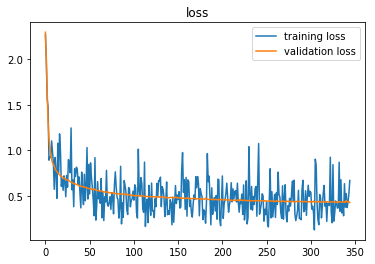

Plotting metrics...


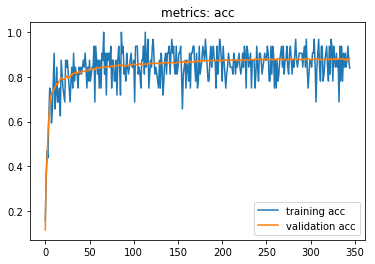

train {'acc': 0.87707275}
test {'acc': 0.8739}


In [24]:
if try_cls2:
    print('Small model')
    small.plt_loss()
    small.plt_metrics()
    train_metric = small.get_metrics(X_train, y_train)
    test_metric = small.get_metrics(X_test, y_test)
    print('train',train_metric)
    print('test',test_metric)

In [25]:

temperatures = [2,4,8,16,32,64]
train_metrics = {}
test_metrics = {}
for temperature in temperatures:
    # initialize metrics
    train_metrics[temperature] = []
    test_metrics[temperature] = []
    # prepare softened data
    y_train_soft = teacher.predict_softened(X_train, temperature)
    y_val_soft = teacher.predict_softened(X_val, temperature)
    y_test_soft = teacher.predict_softened(X_test, temperature)
    for coef_softloss in [1/(temperature**2), 1, temperature**2]:
        print('Training student with temperature =',temperature,', coef =',coef_softloss,'.')
        # build network architecture
        student = build_small_model(input_dims, output_dims, session, is_student=True)
        # train network
        student.soft_train(
            X=X_train
            ,y=y_train
            ,y_soft=y_train_soft
            ,temperature=temperature
            ,coef_softloss= coef_softloss# * temperature**2
            ,val_set=[X_val,y_val,y_val_soft]
            ,batch_size=32
            ,n_epochs=20
            ,display_steps=100)
        # show result
        print('Student performance with temperature =',temperature,', coef =',coef_softloss,'.')
        student.plt_loss()
        student.plt_metrics()
        train_metric = student.get_metrics(X_train, y_train)
        test_metric = student.get_metrics(X_test, y_test)
        print('train',train_metric)
        print('test',test_metric)
        print()
        train_metrics[temperature].append(train_metric)
        test_metrics[temperature].append(test_metric)
        gc.collect()

Training student with temperature = 2 , coef = 4 .
Epoch 1 , step 0 , loss= 11.4654 val_loss= 11.490796 , acc = 0.1875 val acc = 0.0946 
Epoch 1 , step 100 , loss= 11.1092 val_loss= 11.115192 , acc = 0.21875 val acc = 0.1572 
Epoch 1 , step 200 , loss= 10.971261 val_loss= 10.915095 , acc = 0.15625 val acc = 0.2834 
Epoch 1 , step 300 , loss= 10.846955 val_loss= 10.800271 , acc = 0.375 val acc = 0.4062 
Epoch 1 , step 400 , loss= 11.022465 val_loss= 10.712525 , acc = 0.25 val acc = 0.4346 
Epoch 1 , step 500 , loss= 10.614459 val_loss= 10.659089 , acc = 0.5625 val acc = 0.4744 
Epoch 1 , step 600 , loss= 10.410886 val_loss= 10.627358 , acc = 0.65625 val acc = 0.4972 
Epoch 1 , step 700 , loss= 10.560835 val_loss= 10.598906 , acc = 0.46875 val acc = 0.5228 
Epoch 1 , step 800 , loss= 10.744639 val_loss= 10.590179 , acc = 0.5625 val acc = 0.5454 
Epoch 1 , step 900 , loss= 10.635666 val_loss= 10.578635 , acc = 0.5625 val acc = 0.5558 
Epoch 1 , step 1000 , loss= 10.788486 val_loss= 10.563

KeyboardInterrupt: 

In [ ]:
print(test_metrics)

In [ ]:
# plot and show sample # deprecated
if try_cls2 and True:
    n_samples = 6
    round_show = 4
    n_data = X_test.shape[0]
    indices = np.random.choice(n_data,n_samples)
    for i in range(n_samples):
        sample = X_test[[indices[i]]]
        label = y_test[indices[i]]
        plt.imshow(sample.reshape((28,28)), cmap='gray')
        plt.show()
        pred = student.predict(sample)
        pred_t = student.predict_softened(sample, temperature=temperature)
        print(label)
        print(np.round(pred,round_show))
        print(np.round(pred_t,round_show))
#         print(np.round(pred_t2,round_show))
        #     student.predict()

In [ ]:
# close_session(session)